## Introducción

Este notebook tiene como propósito tomar el conjunto de datos `student-mat.csv` e intentar desarrollar un modelo predictivo mediante una regresión lineal múltiple y analizar los resultados obtenidos. El objetivo es predecir la nota final de los estudiantes en función de cerca de treinta variables relacionadas, por lo que primero se hará un análisis de cuales variables son las más relevantes para nuestro modelo y que resultados se pueden obtener.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from ydata_profiling import ProfileReport
from IPython.display import display
from sklearn.model_selection import train_test_split

## Análisis exploratorio de datos

En primera instancia se realiza un análisis mediante `ydata-profiling`, el cual genera un reporte completo del dataset, incluyendo estadísticas descriptivas, correlaciones, distribuciones de variables, etc. Este análisis es útil para entender la calidad de los datos y detectar posibles problemas como valores faltantes o outliers.

Las líneas están comentadas porque el reporte toma tiempo y ya está generado y guardado en la carpeta `output`. Pero si se quiere ejecutar basta con descomentar las líneas y ejecutar el bloque.

In [4]:
# Carga del dataset en un dataframe y visualizacion de los primeros 5 registros.
df = pd.read_csv("../data/student-mat.csv", delimiter=";")
print(np.shape(df)) # este comando imprime la forma del dataframe
df.head(10)

(395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,14,15,15


Es recomendable no ejecutar la siguiente celda, la idea de esto es generar un reporte amplio y puede tardar bastante tiempo, lo mejor es ir a la carpeta `output` y abrir el archivo `student-report.html` para ver el reporte. Para eso haga click derecho en el archivo y seleccione `open with` y luego `web browser` y seleccione su navegador preferido.

In [5]:
# Generación del reporte y guardado en un archivo HTML en la carpeta output.
#profile = ProfileReport(df, title="Student Performance Report")
#profile.to_file("../output/student-report.html")

A modo de recomendación del profesor, se tienen los siguientes comentarios:
* Considere que G3 tiene una fuerte correlación con G2 y G1, pero los modelos más útiles son
aquellos que no utilizan estas dos variables.
* Codifique las variables categóricas (por ejemplo, utilizando codificación one-hot).
* Divida los datos en conjuntos de entrenamiento y prueba
---
Revisando el [sitio oficial del set de datos](https://archive.ics.uci.edu/dataset/320/student+performance) se tiene que:
El conjunto de datos aborda el rendimiento estudiantil en educación secundaria de dos escuelas portuguesas, acá se menciona que:
* G3 es la calificación final de año del estudiante.
* G1 y G2 son las calificaciones de los dos primeros periodos del año.

Es por esto que se recomienda no usar G1 y G2 para predecir G3, ya que no utilizarlas nos daría una predicción más útil.

In [6]:
# Primero hay que ver el tipo de variables que manejan.
df.info()
# Ahora guardamos las variables de tipo object, estas son las variables categóricas.
cat_cols = df.select_dtypes(include='object').columns.tolist()
print(cat_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

## Codificación One-Hot

La codificación **One-Hot Encoding** es una técnica para convertir variables categóricas en variables numéricas binarias (0 o 1), creando una columna para cada categoría posible. Esto es necesario para que muchos modelos de machine learning puedan procesar variables categóricas correctamente.

En pandas, se puede realizar fácilmente usando la función `get_dummies()`, que transforma las columnas categóricas en múltiples columnas binarias. La opción `drop_first=True` permite evitar la multicolinealidad eliminando una de las categorías por variable.

In [7]:
# Se aplica la codificación one-hot a las variables categóricas y se visualizan
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.head(10)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,True,False,False,False,True,True,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,False,True,False,False,False,True,True,False
2,15,1,1,1,2,3,4,3,2,2,...,True,False,True,False,True,False,True,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,True,False,False,True,True,True,True,True,True,True
4,16,3,3,1,2,0,4,3,2,1,...,False,False,False,True,True,False,True,True,False,False
5,16,4,3,1,2,0,5,4,2,1,...,True,False,False,True,True,True,True,True,True,False
6,16,2,2,1,2,0,4,4,4,1,...,True,False,False,False,False,False,True,True,True,False
7,17,4,4,2,2,0,4,1,4,1,...,True,False,True,True,False,False,True,True,False,False
8,15,3,2,1,2,0,4,2,2,1,...,True,False,False,True,True,False,True,True,True,False
9,15,3,4,1,2,0,5,5,1,1,...,True,False,False,True,True,True,True,True,True,False


In [8]:
# Las columnas a las que se aplicó la codificación one-hot quedaron con valores booleanos,
# es preferible que sean 0 y 1, así que se va a arreglar eso. Como el resto de variables ya era int, se hará lo siguiente:
df_encoded = df_encoded.astype(int)
df_encoded.drop(columns=['G1', 'G2'], inplace=True)  # Se eliminan G1 y G2
print(df_encoded.info())
df_encoded.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                395 non-null    int64
 1   Medu               395 non-null    int64
 2   Fedu               395 non-null    int64
 3   traveltime         395 non-null    int64
 4   studytime          395 non-null    int64
 5   failures           395 non-null    int64
 6   famrel             395 non-null    int64
 7   freetime           395 non-null    int64
 8   goout              395 non-null    int64
 9   Dalc               395 non-null    int64
 10  Walc               395 non-null    int64
 11  health             395 non-null    int64
 12  absences           395 non-null    int64
 13  G3                 395 non-null    int64
 14  school_MS          395 non-null    int64
 15  sex_M              395 non-null    int64
 16  address_U          395 non-null    int64
 17  famsize_LE3     

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,1,0,0,0,1,1,0,0
1,17,1,1,1,2,0,5,3,3,1,...,0,0,0,1,0,0,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,1,0,1,0,1,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,1,0,0,1,1,1,1,1,1,1
4,16,3,3,1,2,0,4,3,2,1,...,0,0,0,1,1,0,1,1,0,0
5,16,4,3,1,2,0,5,4,2,1,...,1,0,0,1,1,1,1,1,1,0
6,16,2,2,1,2,0,4,4,4,1,...,1,0,0,0,0,0,1,1,1,0
7,17,4,4,2,2,0,4,1,4,1,...,1,0,1,1,0,0,1,1,0,0
8,15,3,2,1,2,0,4,2,2,1,...,1,0,0,1,1,0,1,1,1,0
9,15,3,4,1,2,0,5,5,1,1,...,1,0,0,1,1,1,1,1,1,0


## Gráficos
Voy a mostrar un scatterplot y un boxplot de todas las variables para ver como se relacionan

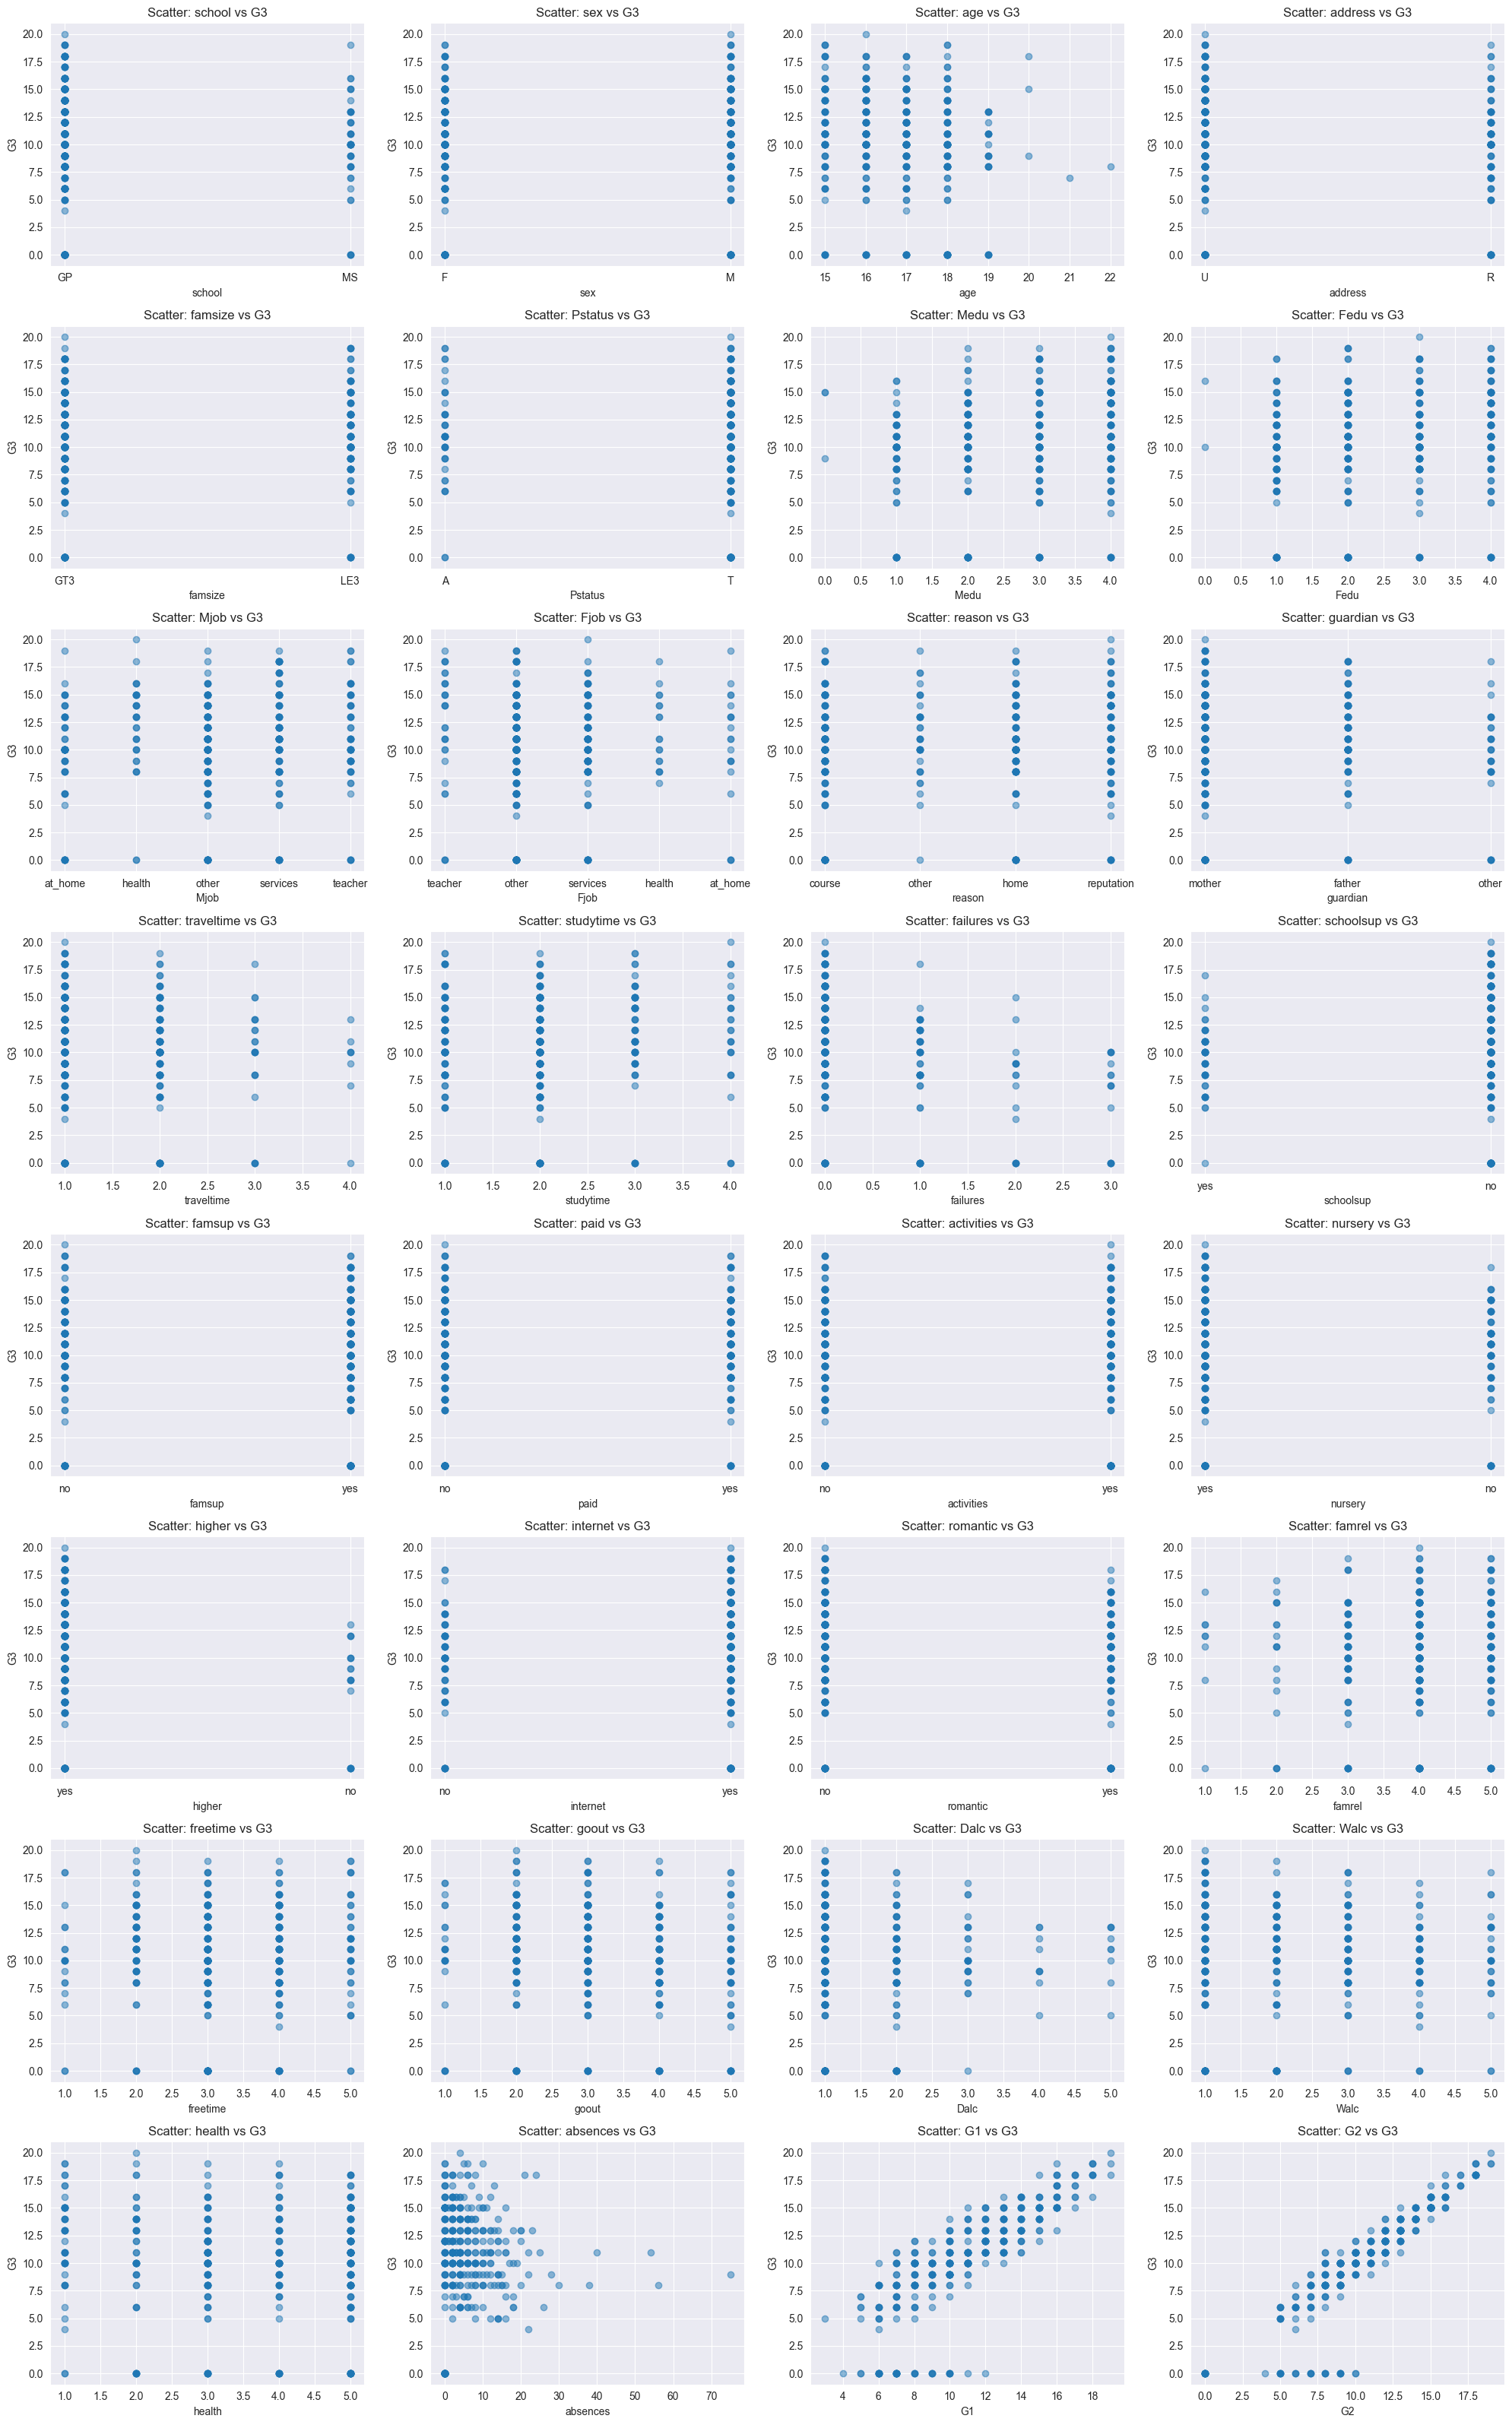

In [9]:
# Scatter plot de todas las variables con G3
y = df_encoded['G3']              # Variable objetivo
X = df.drop(columns=['G3'])  # Variables independientes

num_features = X.shape[1]
cols = 4
rows = (num_features // cols) + (num_features % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.flatten()

for i, col_name in enumerate(X.columns):
    axes[i].scatter(X[col_name], y, alpha=0.5)
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('G3')
    axes[i].set_title(f'Scatter: {col_name} vs G3')

# Quitar los ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

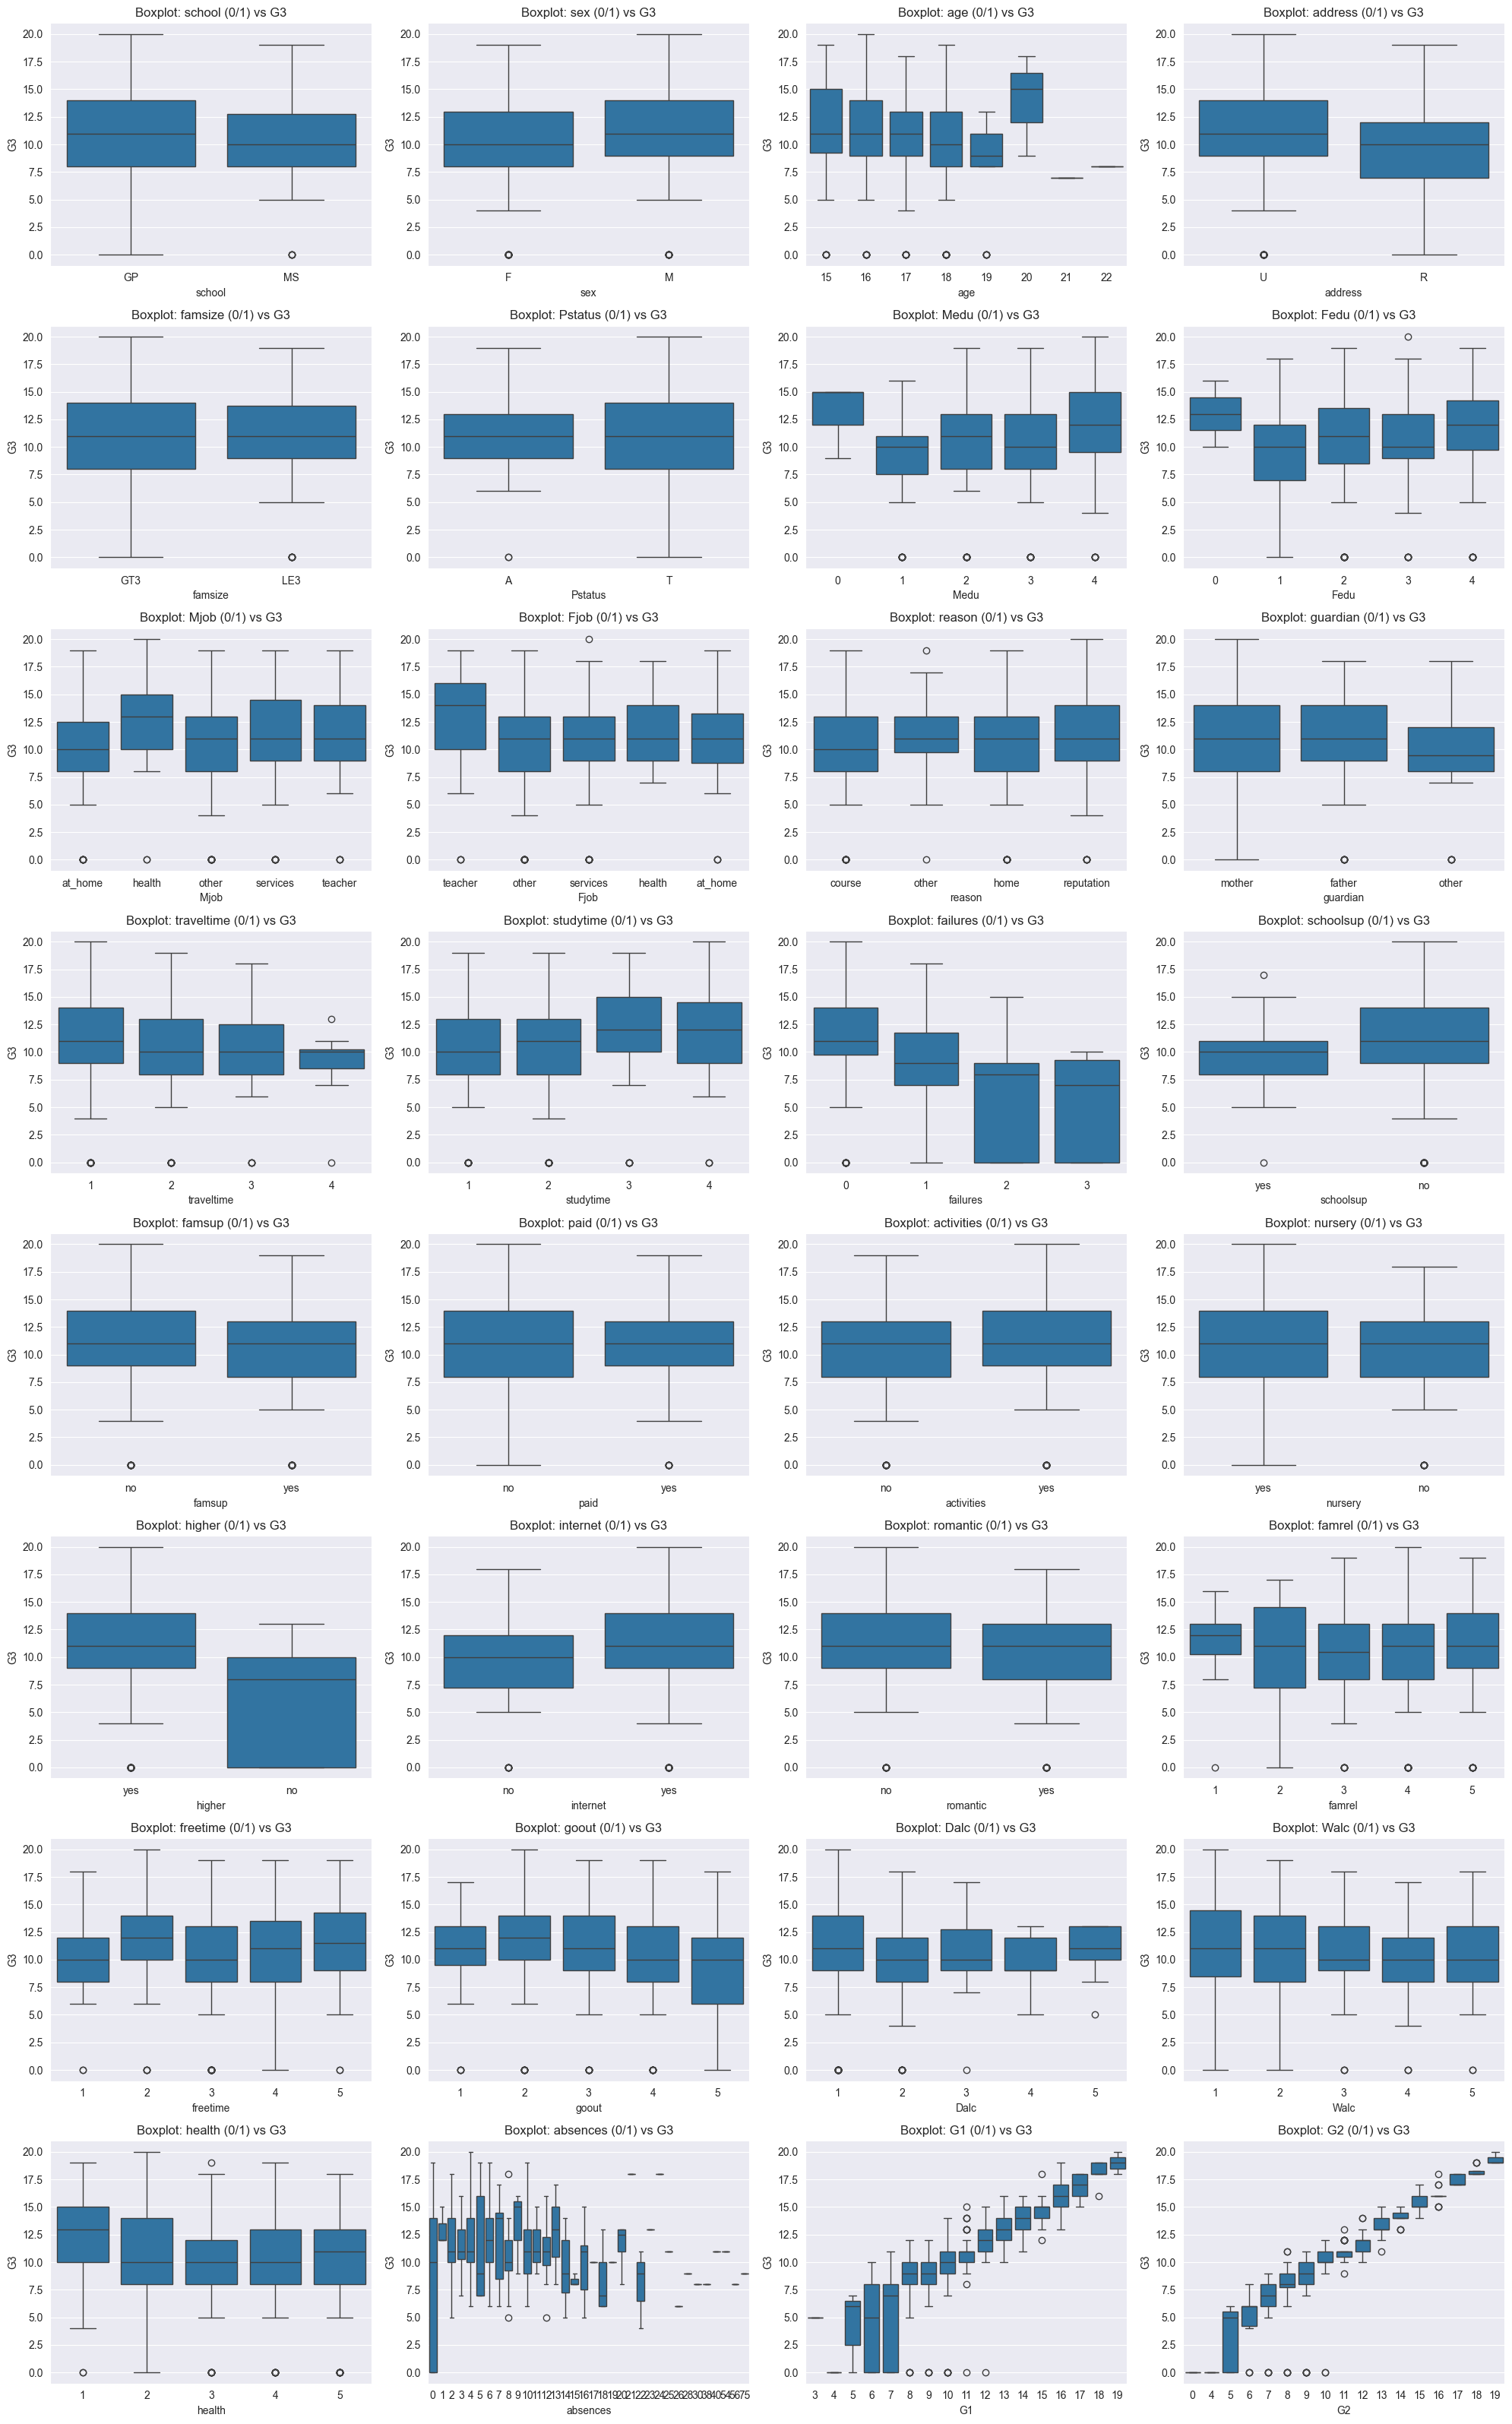

In [10]:
# El scatter plot no dio mucha información, por lo que se va a usar un boxplot para ver la relación entre las variables categóricas y G3
y = df_encoded['G3']              # Variable objetivo
X = df.drop(columns=['G3'])  # Variables independientes
cols = 4
num_features = X.shape[1]
rows = (num_features // cols) + (num_features % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.flatten()

for i, col_name in enumerate(X.columns):
    sns.boxplot(x=X[col_name], y=y, ax=axes[i])
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('G3')
    axes[i].set_title(f'Boxplot: {col_name} (0/1) vs G3')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

A partir de los box plots se puede ver que muchas de las columnas están en rangos parecidos y no parece haber muchas características que puedan ayudar de verdad, por lo que se hará una matriz de correlación para ver como se comportan las características entre si.

In [11]:
corr_matrix = df_encoded.corr()
# Con tantas variables se ve asquerosamente mal la matriz como un heatmap, así que se mostrará como tabla.
display(corr_matrix.style.set_sticky(axis="columns"))

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
age,1.000000,-0.163658,-0.163438,0.070641,-0.004140,0.243665,0.053940,0.016434,0.126964,0.131125,0.117276,-0.062187,0.175230,-0.161579,0.377610,-0.028606,-0.146722,0.037847,0.029598,-0.082660,0.032488,-0.007732,-0.058256,-0.109842,0.007682,0.042963,-0.069993,0.018283,0.027172,-0.031932,-0.133558,0.398396,-0.251811,-0.140609,-0.035933,-0.103063,-0.086632,-0.209081,-0.112094,0.164669
Medu,-0.163658,1.000000,0.623455,-0.171639,0.064944,-0.236680,-0.003914,0.030891,0.064094,0.019834,-0.047123,-0.046878,0.100285,0.217147,-0.133333,0.078228,0.138804,-0.043068,-0.123565,0.251973,-0.235176,0.051764,0.454911,0.083398,-0.109887,-0.031834,0.259836,-0.008708,0.008229,0.106487,0.112375,-0.118635,-0.036029,0.183727,0.159700,0.108277,0.193263,0.168845,0.201463,0.039681
Fedu,-0.163438,0.623455,1.000000,-0.158194,-0.009175,-0.250408,-0.001370,-0.012846,0.043105,0.002386,-0.012631,0.014742,0.024473,0.152457,-0.079807,0.034878,0.072178,-0.058879,-0.088730,0.118501,-0.197077,0.028032,0.294526,0.163216,-0.253605,0.021306,0.347203,-0.009618,-0.014364,0.048724,-0.047265,-0.091250,0.037530,0.185496,0.086981,0.112643,0.157177,0.174566,0.127507,0.015602
traveltime,0.070641,-0.171639,-0.158194,1.000000,-0.100909,0.092239,-0.016808,-0.017025,0.028540,0.138325,0.134116,0.007501,-0.012944,-0.117142,0.242308,0.059722,-0.328096,0.063493,0.028265,-0.106708,0.036544,-0.050943,-0.051235,-0.088277,0.093214,-0.030232,0.014004,-0.080027,-0.001662,-0.033322,-0.057669,0.048758,-0.009246,-0.003286,-0.066420,-0.007766,-0.033338,-0.083508,-0.111302,0.021962
studytime,-0.004140,0.064944,-0.009175,-0.100909,1.000000,-0.173563,0.039731,-0.143198,-0.063904,-0.196019,-0.253785,-0.075616,-0.062700,0.097820,-0.090681,-0.306268,-0.020912,-0.073595,0.024294,-0.012977,-0.006288,-0.004476,-0.009009,0.121107,-0.040619,0.007162,-0.058225,-0.039620,-0.107842,0.193342,-0.024031,0.031724,0.037763,0.145228,0.167220,0.089877,0.081325,0.175081,0.059422,0.053285
failures,0.243665,-0.236680,-0.250408,0.092239,-0.173563,1.000000,-0.044337,0.091987,0.124561,0.136047,0.141962,0.065827,0.063726,-0.360415,0.059804,0.044436,-0.078578,-0.015769,-0.003339,-0.040859,0.006268,0.105430,-0.157771,-0.016593,-0.037792,0.082706,-0.074377,0.042511,-0.012203,-0.070127,-0.134498,0.291157,-0.000437,-0.055075,-0.188039,-0.069341,-0.100734,-0.300316,-0.063451,0.093137
famrel,0.053940,-0.003914,-0.001370,-0.016808,0.039731,-0.044337,1.000000,0.150701,0.064568,-0.077594,-0.113397,0.094056,-0.044354,0.051363,-0.047926,0.058971,0.014258,-0.022776,0.025179,-0.061548,0.022736,0.056255,-0.022122,-0.013521,0.017534,0.051461,-0.069204,-0.012201,-0.019595,-0.000972,-0.010983,0.049548,-0.001345,-0.020436,0.000460,0.040687,-0.003581,0.024319,0.032768,-0.063816
freetime,0.016434,0.030891,-0.012846,-0.017025,-0.143198,0.091987,0.150701,1.000000,0.285019,0.209001,0.147822,0.075733,-0.058078,0.011307,0.032988,0.238744,0.034878,0.017695,0.038717,-0.009094,-0.011640,0.021672,0.088508,-0.063738,0.040338,-0.051570,0.001675,-0.083249,0.039891,-0.050101,-0.028979,0.069438,-0.045465,0.010538,-0.064253,0.089728,-0.024696,-0.061244,0.051286,-0.011182
goout,0.126964,0.064094,0.043105,0.028540,-0.063904,0.124561,0.064568,0.285019,1.000000,0.266994,0.420386,-0.009577,0.044302,-0.132791,-0.007152,0.075897,0.068835,0.023064,0.003459,0.059252,-0.001660,0.014455,-0.021319,-0.021394,0.047488,-0.010554,-0.018830,-0.004410,-0.015182,-0.038297,0.080236,-0.012380,-0.037698,-0.015631,0.010493,0.046088,0.004612,-0.039700,0.074370,0.007870
Dalc,0.131125,0.019834,0.002386,0.138325,-0.196019,0.136047,-0.077594,0.209001,0.266994,1.000000,0.6475

In [12]:
# La tabla sigue siendo demasiado grande para interpretar bien los datos, así que voy a extraer G3
# y mostrar la correlación con el resto de columnas menos G1 y G2
corr_with_G3 = corr_matrix.corr()['G3']

# La idea igual es usar valor absoluto y ordenarlos para ver que tan fuerte es la correlación, más allá si es positiva o negativa
corr_with_G3_sorted = corr_with_G3.reindex(corr_with_G3.abs().sort_values(ascending=False).index)
display(corr_with_G3_sorted.to_frame(name='Correlation with G3').style.set_sticky(axis="index"))

,Correlation with G3
G3,1.000000
failures,-0.680531
Medu,0.476502
higher_yes,0.433526
age,-0.432501
Fedu,0.410246
traveltime,-0.352092
guardian_other,-0.315268
goout,-0.303937
romantic_yes,-0.299414


Para ver que variables incluir en todo esto seleccionaré todas las que sean mayores a 0.3 en valor absoluto y algunas seleccionadas personalmente que siento que podrían hacer sentido.
Algunas variables que no se entienden solamente con el nombre las definiré acá abajo:
* Pstatus: Si sus padres viven juntos o separados, juntos = 1, separados = 0
* Medu: Educación de la madre
* higher_yes es si quiere tomar educación superior o no
* El trabajo de la madre tiene bastante correlacion pero al ser como cuatro variables primero lo veré sin ella y luego lo incluiré si es necesario.


In [13]:
#selected_features = ['failures', 'Medu', 'higher_yes', 'age', 'goout', 'Fedu', 'traveltime',
#                     'romantic_yes', 'Pstatus_T', 'studytime', 'schoolsup_yes', 'guardian_other',
#                     'guardian_mother', 'paid_yes', 'activities_yes', 'internet_yes', 'freetime', 'absences']

selected_features = ['higher_yes','schoolsup_yes','absences','failures', 'Pstatus_T', 'guardian_other','guardian_mother']

X = df_encoded[selected_features]

#X = df_encoded.drop("G3", axis=1)

y = df_encoded['G3']

Voy a graficar un scatterplot para ver como se ven las variables seleccionadas con G3, para ver si hay alguna relación lineal entre ellas.

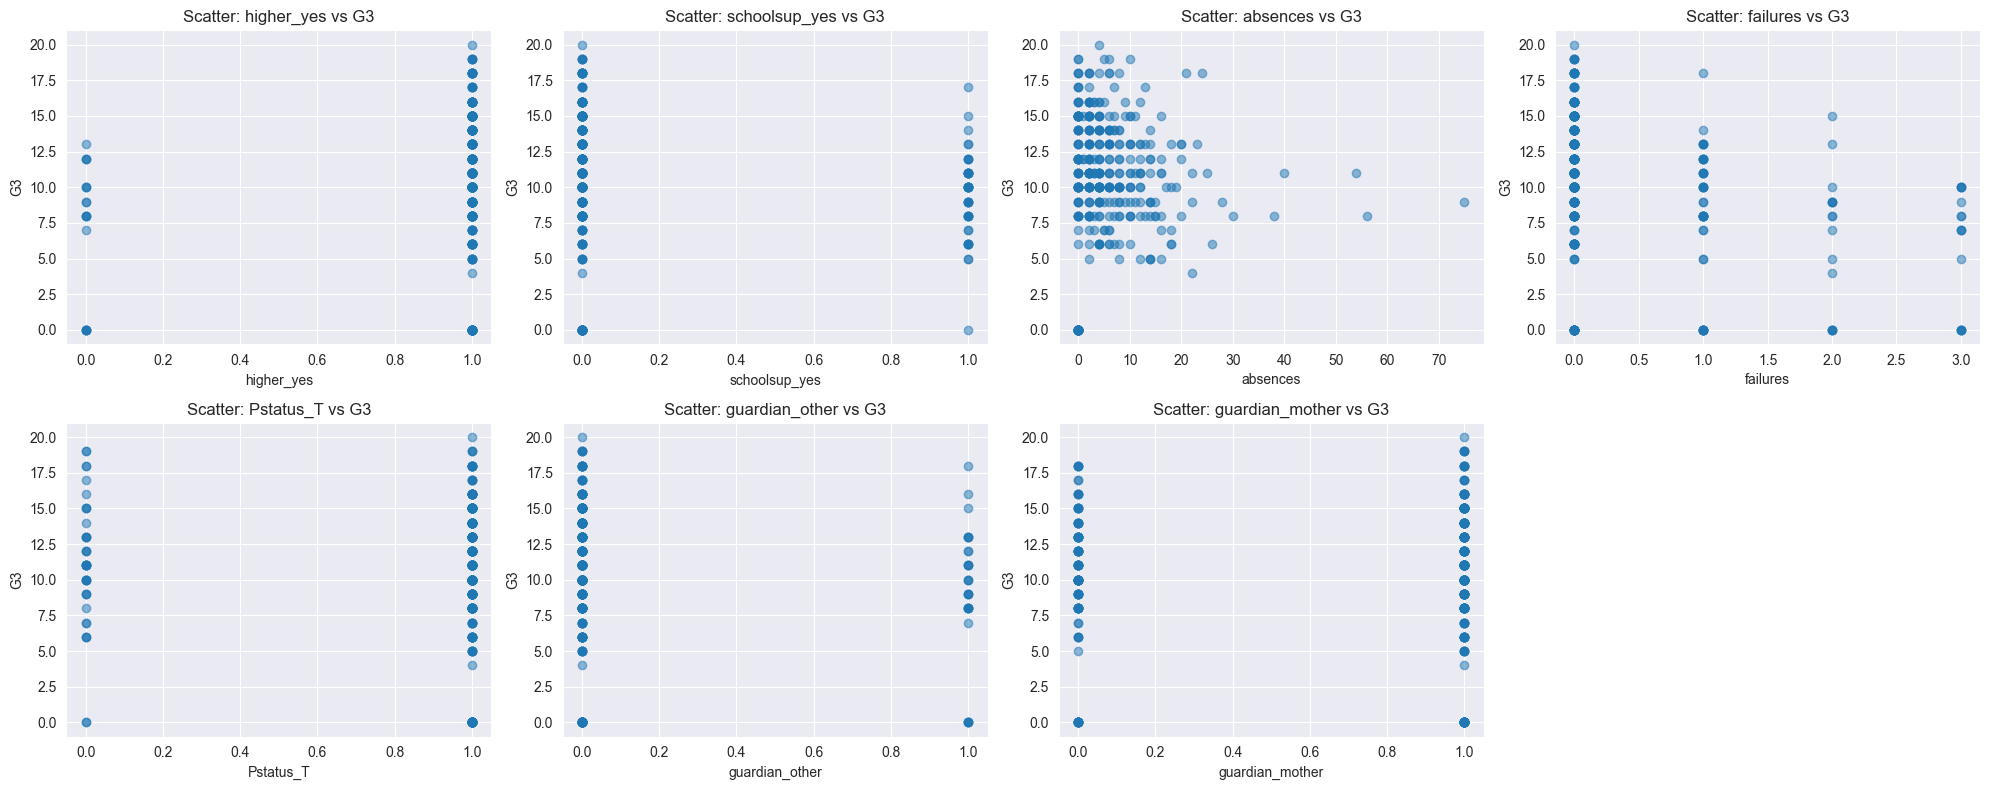

In [14]:
num_features = X.shape[1]
cols = 4
rows = (num_features // cols) + (num_features % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.flatten()

for i, col_name in enumerate(X.columns):
    axes[i].scatter(X[col_name], y, alpha=0.5)
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('G3')
    axes[i].set_title(f'Scatter: {col_name} vs G3')

# Quitar los ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


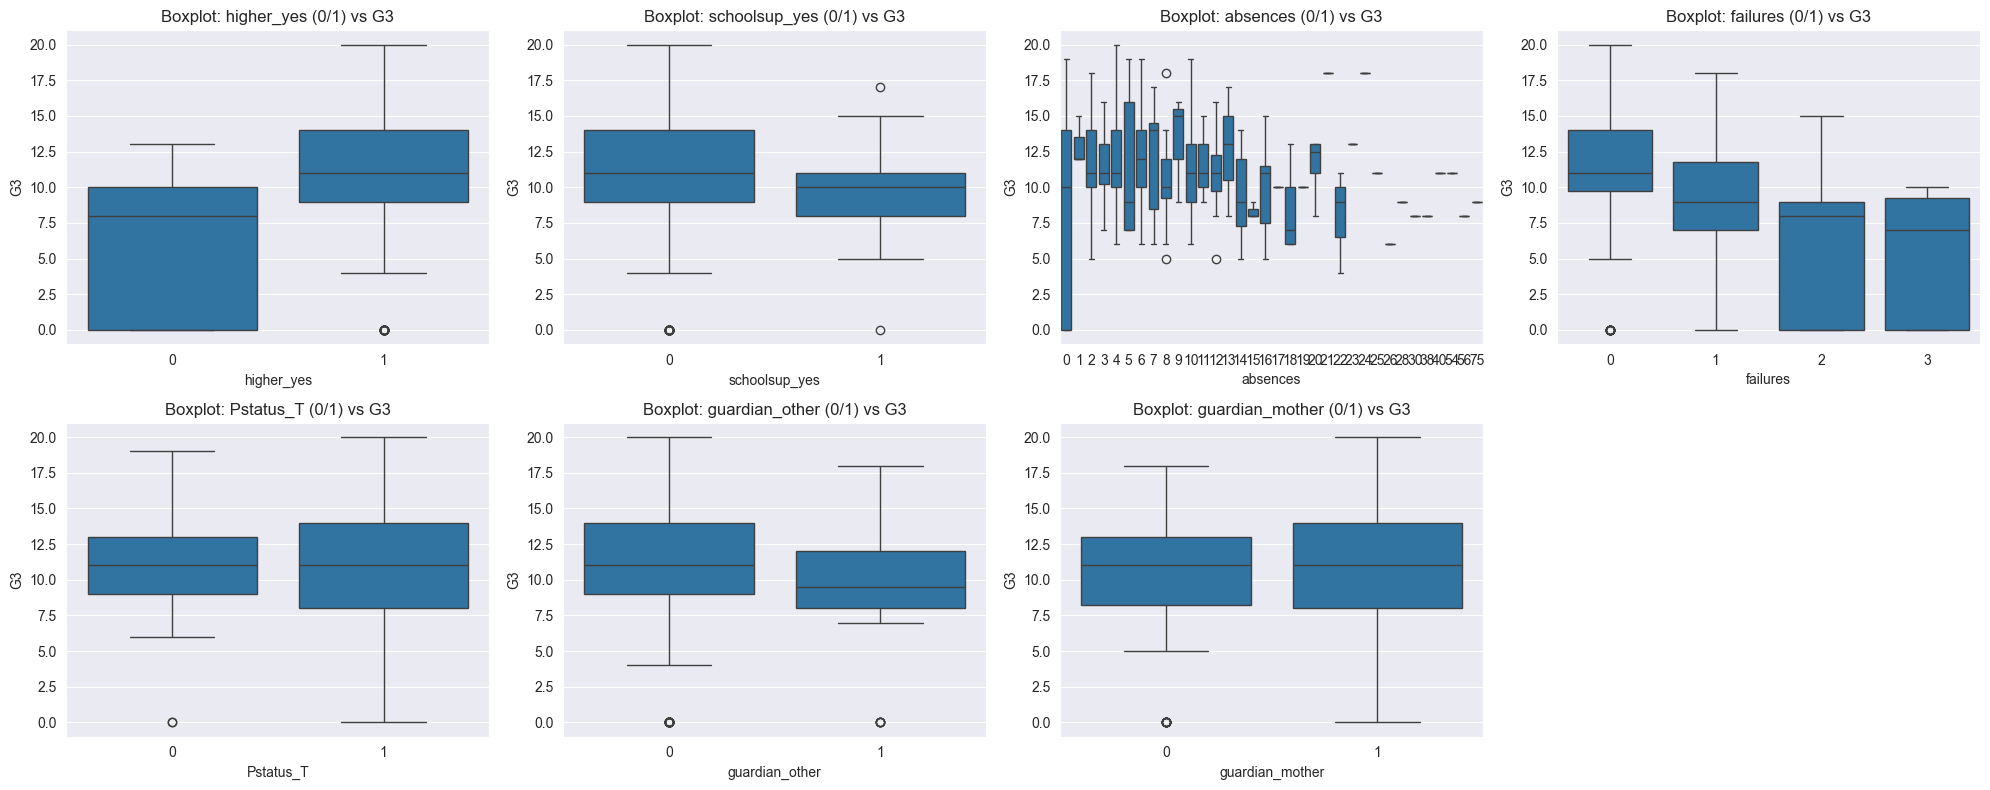

In [15]:
# El scatter plot no dio mucha información, por lo que se va a usar un boxplot para ver la relación entre las variables categóricas y G3
cols = 4
num_features = X.shape[1]
rows = (num_features // cols) + (num_features % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.flatten()

for i, col_name in enumerate(X.columns):
    sns.boxplot(x=X[col_name], y=y, ax=axes[i])
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('G3')
    axes[i].set_title(f'Boxplot: {col_name} (0/1) vs G3')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Construcción de los conjuntos de entrenamiento y prueba

Ahora que se tiene definido que características se van a utilizar para entrenar el modelo, hay que obtener los valores y guardarlos en variables diferentes, se va a normalizar tanto la entrada como la salida para que estén en un mismo rango y se pueda analizar bien la información. Se separó el conjunto en 80% entrenamiento y 20% prueba.

In [16]:
X = X.values
y = y.values

np.random.seed(0)

# Normalización
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = (y - np.mean(y)) / np.std(y)

# Añadir columna de unos para el intercepto
X = np.hstack((np.ones((X.shape[0], 1)), X))

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Training data:", X_train.shape)
print("Test data:", X_test.shape)

Training data: (316, 8)
Test data: (79, 8)


## Información luego de normalizar

Realmente este bloque y el siguiente son más gráficos para ver si el comportamiento cambiaba por milagro porque no podía obtener valores más altos en las predicciones, así que están para ver si algo cambió.

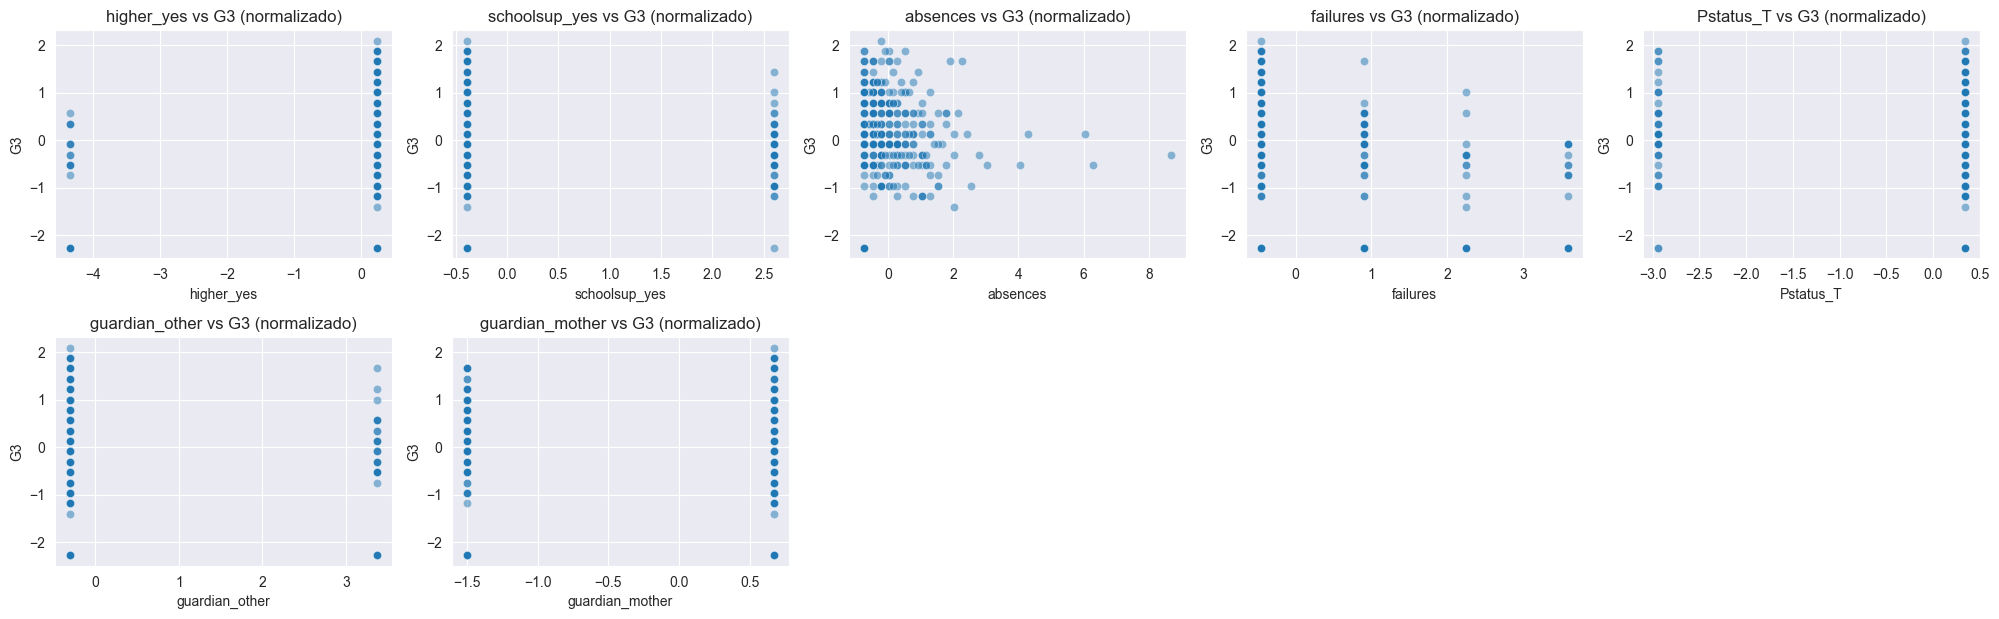

In [17]:
# Después de normalizar
X_df = pd.DataFrame(X[:, 1:], columns=selected_features)  # quitamos columna de 1s
y_normalized = y

fig, axes = plt.subplots(4, 5, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(X_df.columns):
    sns.scatterplot(x=X_df[col], y=y_normalized, ax=axes[i], alpha=0.5)
    axes[i].set_title(f"{col} vs G3 (normalizado)")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("G3")

# Eliminar ejes vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

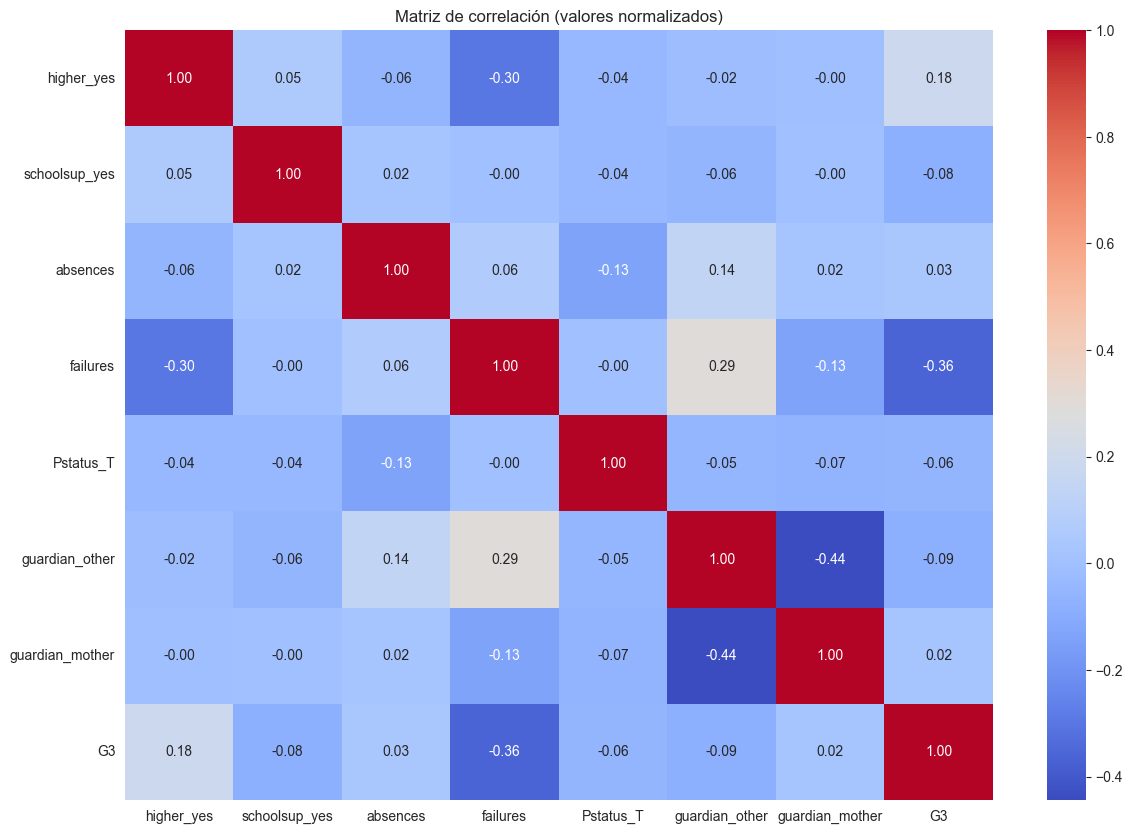

In [18]:
# Se realizó un heatmap en la matriz de correlación para ver como interactúan las variables escogidas.
# Incluimos G3 normalizado
df_corr = pd.DataFrame(X[:, 1:], columns=selected_features)
df_corr['G3'] = y  # y ya está normalizado

plt.figure(figsize=(14,10))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación (valores normalizados)")
plt.show()


## Modelo de regresión lineal múltiple
El modelo de regresión lineal tiene la forma:

$$ \hat{y} = \beta_0 + \beta_{1}*x_{1} + \beta_{2}*x_{2} + ... + \beta_{n}*x_{n} $$

$$\hat{y}=X\beta$$

Donde $\hat{y}$ es la predicción que queremos hacer

$\beta_0$ es el término independiente

$\beta_{n}$ es un vector de coeficientes

$x_{n}$ son los valores de las variables independientes del dataset.

El objetivo es obtener $\beta_0$ y $\beta_{n}$  tales que error cuadrático (residuo) , definido como:

$$RSS = \varepsilon_i^2 = \sum\limits_{i=1}^n(y_{i} - \hat{y})^2$$

Sea el mínimo.

Para ello se tiene que resolver la siguiente ecuación:

$$\beta = (X^TX)^{-1}X^Ty$$
$$\hat{y} = X(X^TX)^{-1}X^Ty $$

## Calculo de los coeficientes beta

In [19]:
def coeficiente(X, y):
  X_T = np.transpose(X)
  betas = np.linalg.inv(X_T @ X) @ X_T @ y
  return betas

betas = coeficiente(X_train,y_train)
print("Coeficientes:",betas)

Coeficientes: [ 0.01278729  0.10373849 -0.06259404  0.06662821 -0.29388022 -0.04666904
 -0.05327189 -0.03703554]


## Predicciones y pruebas entre los valores predichos y los reales

In [20]:
y_pred = np.sum(betas*X_test, axis=1)
print("Predicciones:",y_pred[0:20])
print("Real:",y_test[0:20])

Predicciones: [0.15400682 0.2008228  0.19568614 0.1373351  0.1373351  0.17067855
 0.08701155 0.17067855 0.24250211 0.2008228  0.1373351  0.38413371
 0.18735027 0.00068403 0.1373351  0.21749452 0.30085315 0.12066337
 0.28418142 0.2008228 ]
Real: [ 0.78345552 -0.0907392  -0.30928788  1.0020042   1.22055288  0.34635816
  0.78345552  0.12780948 -0.30928788  1.0020042  -0.0907392   0.12780948
 -0.0907392  -0.52783656  1.0020042   0.78345552  0.34635816 -2.27622599
 -0.0907392   1.22055288]


## Métricas para evaluar el modelo

Para entender qué tan bien el modelo ajusta los datos reales, se utilizan métricas basadas en el error:

- **R² (coeficiente de determinación)**: Mide la proporción de la varianza en la variable dependiente que es explicada por el modelo. Un valor cercano a 1 indica un buen ajuste.
- **MSE (Mean Squared Error)**: Promedio del cuadrado de los errores. Penaliza más los errores grandes y da una idea del error promedio.
- **RMSE (Root Mean Squared Error)**: Raíz cuadrada del MSE, expresa el error en las mismas unidades que la variable objetivo, lo que facilita la interpretación.
- **distribución de los residuos** (errores de predicción): Una distribución aproximadamente normal y centrada en cero indica que el modelo no tiene sesgo sistemático y que los errores están bien distribuidos.

R²: 0.215
MSE: 1.034
RMSE: 1.017


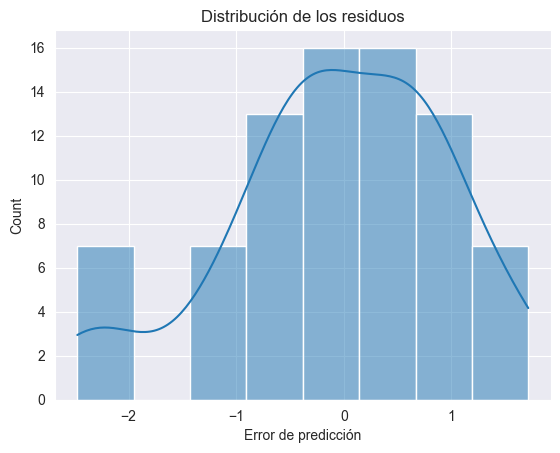

In [22]:
rss = np.sum((y_test - y_pred) ** 2)
tss = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (rss / tss)
mse = mean_squared_error(y_test, y_pred)

print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {np.sqrt(mse):.3f}")
# Distribución de los residuos
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Distribución de los residuos")
plt.xlabel("Error de predicción")
plt.show()

## Conclusión

Por favor no utilicen modelos de regresión cuando existen tantas características, sobre todo si el conjunto de datos es muy complejo.